In [ ]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
df=read_csv('https://raw.githubusercontent.com/kajalpanda1/DatasetRepository/master/Airline_Passengers.csv')

In [ ]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


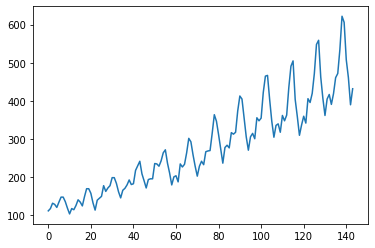

In [ ]:
dataframe=df.iloc[:,1]
plt.plot(dataframe)
plt.show()

In [ ]:
dataset = dataframe.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))
dataset.shape

(144, 1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
print(len(train),len(test))

96 48


In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape,trainY.shape)

(94, 1, 1) (94,)


In [ ]:
print(trainX[0],trainY[0])

[[0.01544401]] 0.027027026


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1,validation_data=(testX, testY))

Epoch 1/100
94/94 [==============================] - 1s 7ms/step - loss: 0.0370 - val_loss: 0.2030
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0174 - val_loss: 0.1356
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.1041
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0911
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0845
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0745
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0601
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0535
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0440
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0313
Epoch 11/

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


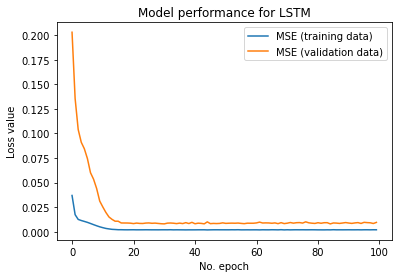

In [ ]:
# Plot history:

plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('Model performance for LSTM')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.78 RMSE
Test Score: 50.62 RMSE


In [ ]:
from sklearn.metrics import r2_score
trainScore = r2_score(trainY[0], trainPredict[:,0])
print('Train Score: %.2f R-square' % (trainScore))
testScore = r2_score(testY[0], testPredict[:,0])
print('Test Score: %.2f R-square' % (testScore))

Train Score: 0.90 R-square
Test Score: 0.58 R-square


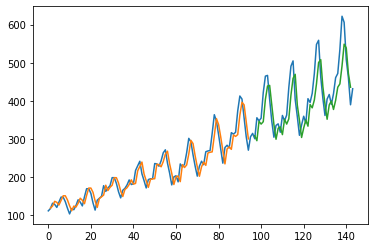

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset) ## returns a new array of same shape and type as the given array
trainPredictPlot.shape
trainPredictPlot[:, :] = numpy.nan

trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()